# Classification with Decision Trees

## Import the libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score

from sklearn.model_selection import cross_val_score, cross_val_predict

## Import and view data

In [24]:
df = pd.read_csv("data/train_prepd.csv")
display(df.head())
print('dims: ', df.shape)

,Survived,Pclass,Age,Fare,FamSize,Sex_male,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Other,cabin_missing
0,0.0,3.0,22.0,7.2500,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,1.0,1.0,38.0,71.2833,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,3.0,26.0,7.9250,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3,1.0,1.0,35.0,53.1000,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.0,3.0,35.0,8.0500,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


dims:  (891, 13)


Decision trees do not support categorical data. Check data types.

In [3]:
df.dtypes

Survived         float64
Pclass           float64
Age              float64
Fare             float64
FamSize          float64
Sex_male         float64
Embarked_Q       float64
Embarked_S       float64
Title_Miss       float64
Title_Mr         float64
Title_Mrs        float64
Title_Other      float64
cabin_missing    float64
dtype: object

Split into dependent and independent variables.

In [4]:
X = df.iloc[:, 1:]
y = df.iloc[:, 0]

## Build a preliminary classification tree

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state = 420)

In [6]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(criterion = 'gini', random_state = 420)
clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=420)

Accuracy: 78.21 %


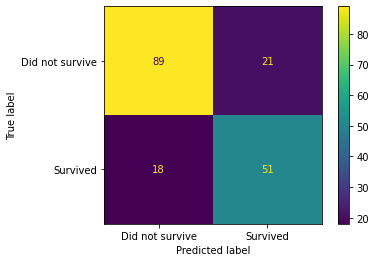

In [7]:
y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
print('Accuracy: {:.2f} %'.format(acc * 100))

plot_confusion_matrix(clf, 
                     X_test,
                     y_test, display_labels=['Did not survive', 'Survived'])

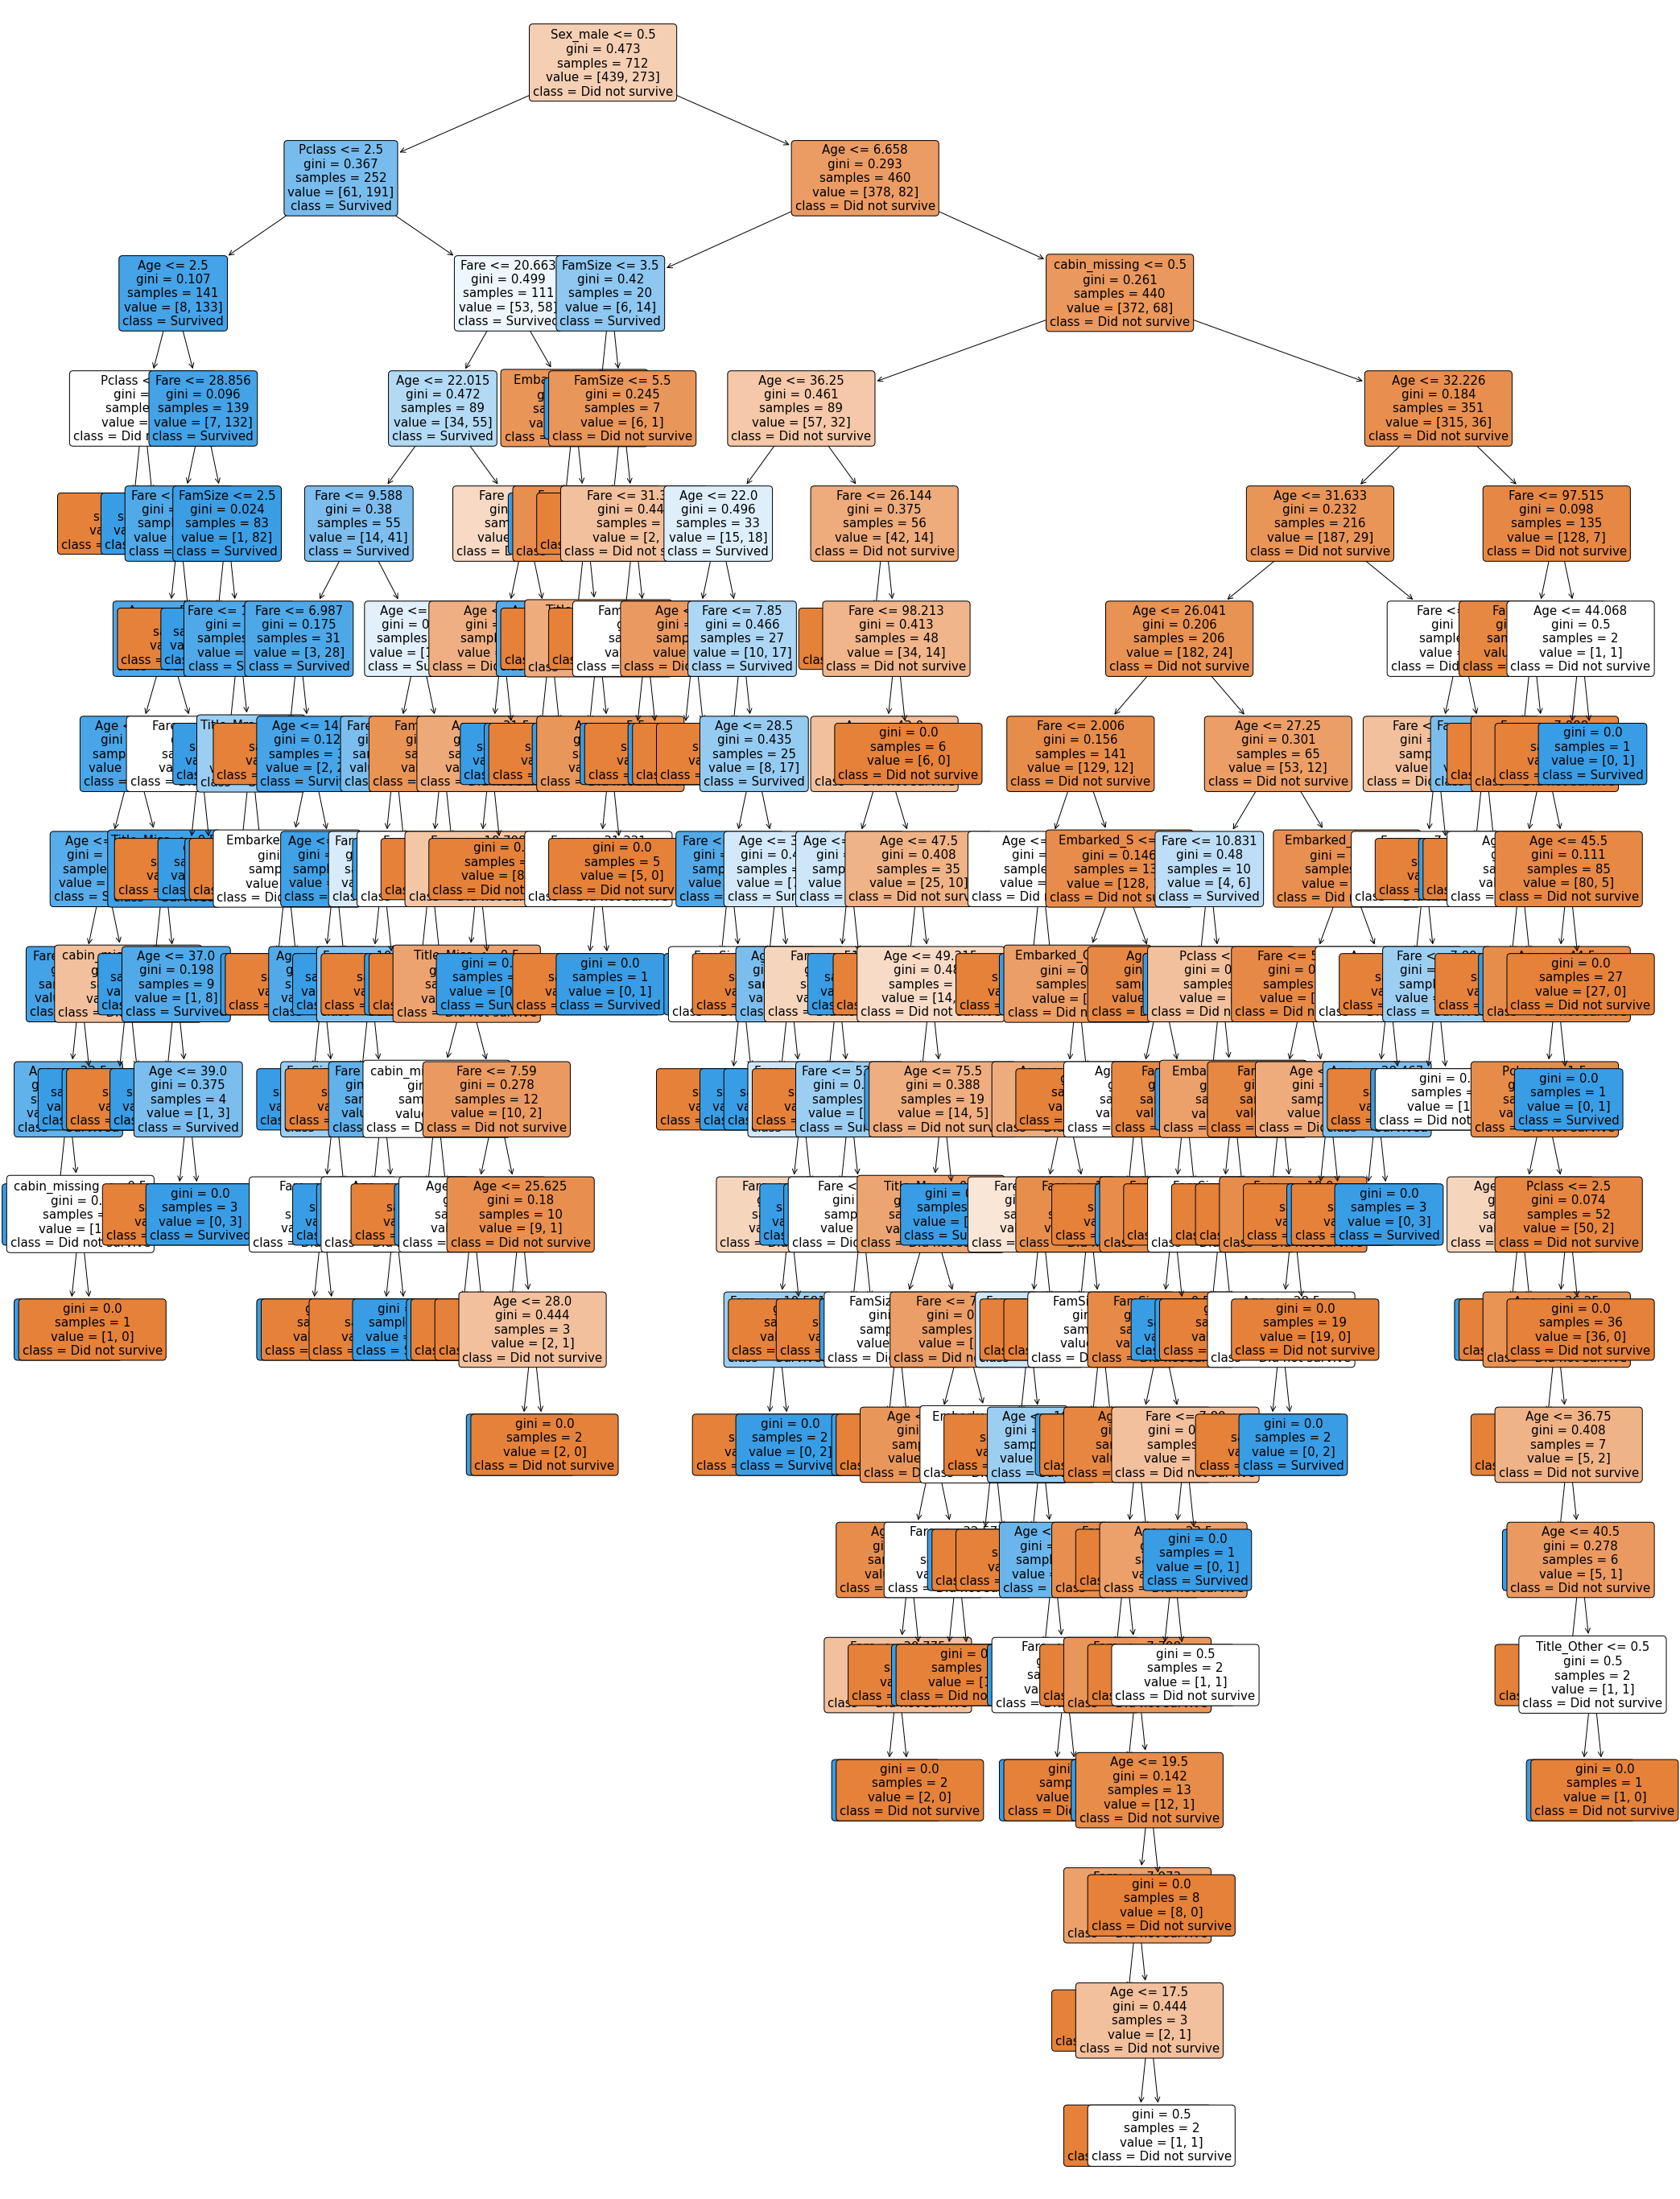

In [8]:
plt.figure(figsize=(35,50))
prel_tree = tree.plot_tree(clf, 
                   feature_names=pd.DataFrame(X).columns, 
                   class_names=["Did not survive", "Survived"],
                   filled=True,
                   rounded=True,
                  fontsize=15)


This is a huge tree, definitely overfitting the training data. Examine the fit on the training set.

Accuracy: 99.58 %


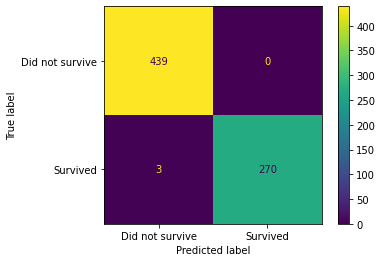

In [9]:
y_pred_tr = clf.predict(X_train)

acc = accuracy_score(y_train, y_pred_tr)
cm = confusion_matrix(y_train, y_pred_tr)
print('Accuracy: {:.2f} %'.format(acc * 100))

plot_confusion_matrix(clf, 
                     X_train,
                     y_train, display_labels=['Did not survive', 'Survived'])

Get a more accurate accuracy of the preliminary tree with 10-fold CV.

In [10]:
scores = cross_val_score(clf, X, y, cv=10)
print('scores: ', scores )
print('Accuracy: {:.2f} %'.format(scores.mean() * 100))
print('St.dev: {:.2f}'.format(scores.std()))

scores:  [0.8        0.83146067 0.70786517 0.80898876 0.84269663 0.84269663
 0.82022472 0.83146067 0.86516854 0.84269663]
Accuracy: 81.93 %
St.dev: 0.04


## Hyperparameter tuning / Pruning the tree

I'm going to attempt to find a smaller tree, to increase bias but lower variance. We will try Cost Complexity Pruning.

First, with a train test split.

In [11]:
# get alpha values from the full tree
clf = DecisionTreeClassifier(criterion = 'gini', random_state = 420)
clf.fit(X_train, y_train)

path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas
# omit the maximum value for alpha, as this is the trivial tree with only a root note.
ccp_alphas = ccp_alphas[:-1]

In [12]:
# fit a tree on each value of alpha and store all of them in a list
dts = []
for alpha in ccp_alphas:
    clf = DecisionTreeClassifier(criterion='gini', random_state=420, ccp_alpha=alpha)
    clf.fit(X_train, y_train)
    dts.append(clf)  

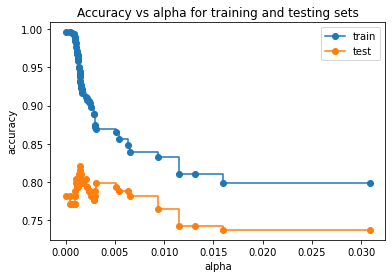

In [13]:
# get train and test scores for each tree
train_scores = [clf.score(X_train, y_train) for clf in dts]
test_scores = [clf.score(X_test, y_test) for clf in dts]


# plot accuracy vs alpha
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

In [14]:
# return the alpha that yields the highest accuracy for the test set
d = {'alpha': ccp_alphas, 'train': train_scores, 'test': test_scores}
df = pd.DataFrame(data=d)

print('best tree: ')
df.loc[df['test'].idxmax()]

best tree: 


alpha    0.001471
train    0.936798
test     0.821229
Name: 31, dtype: float64

Then with cross validation, because different train test splits will result in different model accuracy. 

In [15]:
dts = []
for alpha in ccp_alphas:
    clf = DecisionTreeClassifier(criterion='gini', random_state=420, ccp_alpha=alpha)
    scores = cross_val_score(clf, X_train, y_train, cv=10)
    dts.append([alpha, np.mean(scores), np.std(scores)])

In [16]:
alpha_results = pd.DataFrame(dts, columns=['alpha', 'mean', 'std'])
alpha_results.head(50)

,alpha,mean,std
0,0.000000,0.787969,0.036613
1,0.000396,0.787969,0.036613
2,0.000468,0.787969,0.036613
3,0.000677,0.786561,0.037362
4,0.000803,0.786561,0.037362
5,0.000843,0.786561,0.037362
6,0.000887,0.786561,0.037362
7,0.000906,0.787969,0.040718
8,0.000925,0.787969,0.040718
9,0.000936,0.787969,0.040718


<AxesSubplot:xlabel='alpha'>

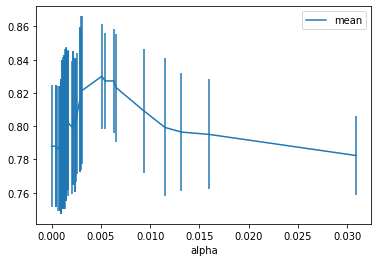

In [17]:
# plot mean accuracy and std. error for different values of alpha
alpha_results.plot(x='alpha', y='mean', yerr='std')

In [18]:
# return the alpha that yields the highest accuracy for the test set
print(alpha_results.loc[alpha_results['mean'].idxmax()])
alpha_best = alpha_results.loc[alpha_results['mean'].idxmax()][0]

alpha    0.005091
mean     0.830086
std      0.031589
Name: 51, dtype: float64


## Build the final model

In [19]:
clf = DecisionTreeClassifier(criterion = 'gini', ccp_alpha=alpha_best, random_state = 420)
clf.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.005091471462510488, random_state=420)

Accuracy: 79.33 %


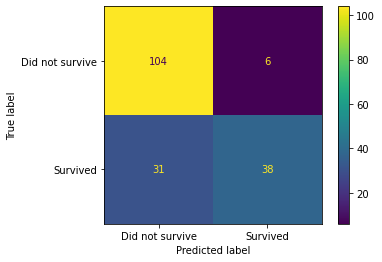

In [20]:
y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
print('Accuracy: {:.2f} %'.format(acc * 100))

plot_confusion_matrix(clf, 
                     X_test,
                     y_test, display_labels=['Did not survive', 'Survived'])

The tree seems to be doing a great job of correctly classifying those that did not survive (95%), but a terrible job at correctly classifying those that survived (55%).

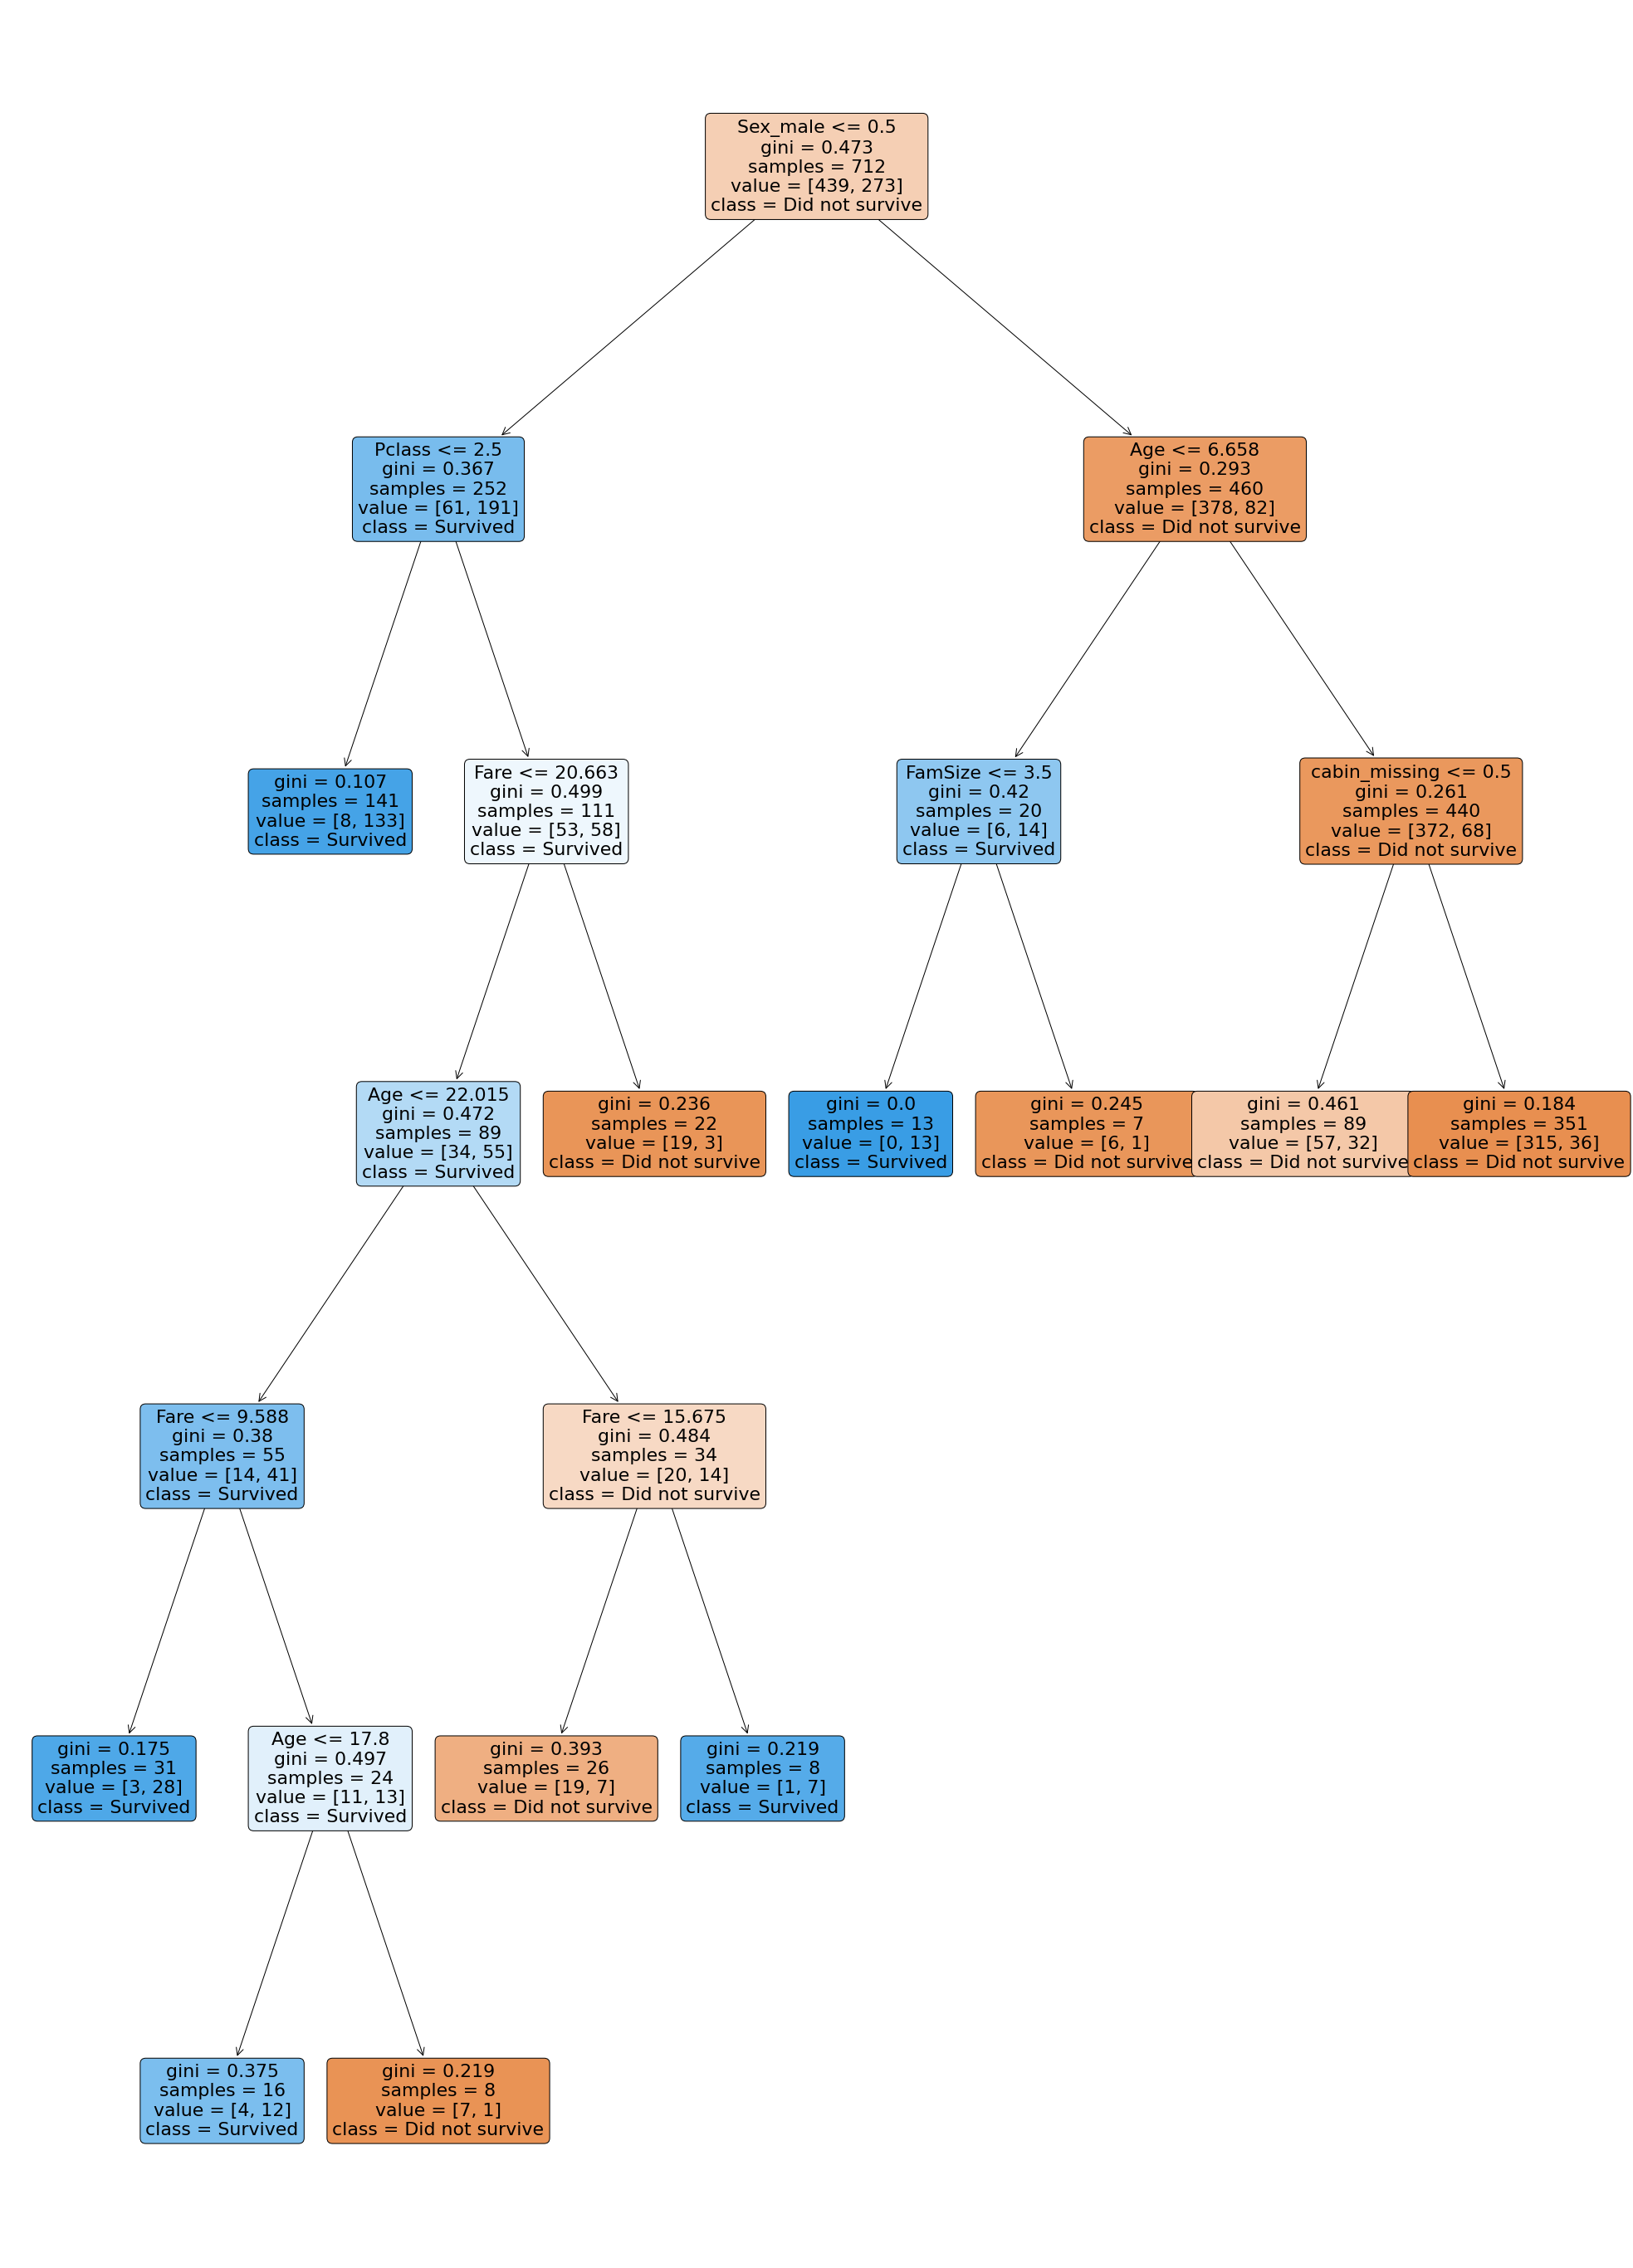

In [21]:
plt.figure(figsize=(35,50))
prel_tree = tree.plot_tree(clf, 
                   feature_names=pd.DataFrame(X).columns, 
                   class_names=["Did not survive", "Survived"],
                   filled=True,
                   rounded=True,
                  fontsize=22)

Accuracy: 86.52 %


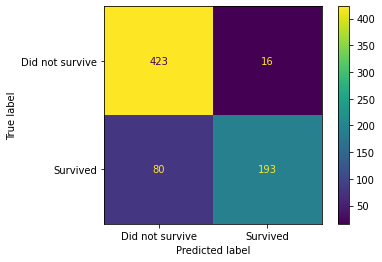

In [22]:
y_pred_tr = clf.predict(X_train)

acc = accuracy_score(y_train, y_pred_tr)
cm = confusion_matrix(y_train, y_pred_tr)
print('Accuracy: {:.2f} %'.format(acc * 100))

plot_confusion_matrix(clf, 
                     X_train,
                     y_train, display_labels=['Did not survive', 'Survived'])

Get a more robust estimate for the model accuracy, using 10-fold CV.

In [23]:
scores = cross_val_score(clf, X, y, cv=10)
print('scores: ', scores )
print('Accuracy: {:.2f} %'.format(scores.mean() * 100))
print('St.dev: {:.2f}'.format(scores.std()))

scores:  [0.81111111 0.79775281 0.71910112 0.88764045 0.84269663 0.82022472
 0.82022472 0.79775281 0.87640449 0.84269663]
Accuracy: 82.16 %
St.dev: 0.04
